In [ ]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from episode.dataset import FeatureTransformer
from episode.episode import EPISODE
from episode.basis import BSplineBasisFunctions
from episode.semantic_representation import Composition
from episode.config import PropertyMapConfig, DecisionTreeConfig
from episode.composition_map import DecisionTreeCompositionMap
from episode.property_map import PropertyMap
from episode.semantic_predictor import SemanticPredictor
from episode.trajectory_predictor import C0TrajectoryPredictor
import matplotlib.pyplot as plt

In [2]:
def get_SIR_dataset(n_samples=100, n_measurements=20, noise_std=0.1, normalize_time=True, seed=0):

    # SIR model differential equations.
    def sir_model(y, t, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I
        dIdt = beta * S * I - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    def predict_sir_trajectories(S0, I0, R0, beta, gamma, timepoints):
        # Initial number of infected and recovered individuals, everyone else is susceptible to infection initially.
        y0 = S0, I0, R0
        # A grid of time points (in days)
        # Integrate the SIR equations over the time grid, t.
        ret = odeint(sir_model, y0, timepoints, args=(beta, gamma))
        return ret
    
    beta = 0.3
    gamma = 0.1
    timepoints = np.linspace(0,100,n_measurements)

    S0_range = (0.6,1.0)
    I0_range = (0.01,0.1)
    R0_range = (0.0,1.0)

    # Create a dataset of initial conditions
    gen = np.random.default_rng(seed=seed)

    S0 = gen.uniform(S0_range[0], S0_range[1], n_samples)
    I0 = gen.uniform(I0_range[0], I0_range[1], n_samples)
    R0 = gen.uniform(R0_range[0], R0_range[1], n_samples)

    # Predict the trajectories
    ys = []
    for i in range(n_samples):
        y = predict_sir_trajectories(S0[i], I0[i], R0[i], beta, gamma, timepoints)
        # add noise
        y += gen.normal(0, noise_std, y.shape)
        ys.append(y)

    Y = np.stack(ys, axis=0)

    T = np.tile(timepoints, (n_samples,1))

    if normalize_time:
        T = T/100

    V = pd.DataFrame(np.stack([S0,I0,R0], axis=1))
    V.columns = ['S0', 'I0', 'R0']

    x0_dict = {0:0,1:1,2:2}

    t_range = (0,1)

    return V, T, Y, x0_dict, t_range

In [3]:
V, T, Y, x0_dict, t_range = get_SIR_dataset(n_samples=50, n_measurements=10, noise_std=0.01, normalize_time=True, seed=0)

In [4]:
feature_transformer = FeatureTransformer()
V = feature_transformer.fit_transform_df(V)

In [5]:
basis_functions = BSplineBasisFunctions(n_basis=6,k=3,include_bias=False, include_linear=True)
# composition_libraries = [Composition.create_full_composition_library(max_length=2, is_infinite=True, simplified=True) for _ in range(3)]

composition_library = [Composition(('--b','-+h',))]


In [6]:
# Fit just one dimension

Y0 = Y[:,:,0]

dt_config = DecisionTreeConfig()

composition_map = DecisionTreeCompositionMap(
    composition_library=composition_library,
    t_range=t_range,
    x0_index=x0_dict[0],
    dt_config=dt_config,
    seed=0,
    verbose=True
)
composition_map.fit(V, T, Y0)


100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


In [7]:
property_map_config = PropertyMapConfig(
    n_epochs=100,
    n_tune=10
)
property_map = PropertyMap(
    basis_functions=basis_functions,
    x0_index=x0_dict[0],
    t_range=t_range,
    config=property_map_config,
    seed=0,
    verbose=True
)
semantic_predictor = SemanticPredictor(
    composition_map=composition_map,
    property_map=property_map
)
trajectory_predictor = C0TrajectoryPredictor()
episode = EPISODE(
    semantic_predictor=semantic_predictor,
    trajectory_predictor=trajectory_predictor,
)

In [8]:
property_map.fit(V, T, Y0, composition_map=composition_map)

[I 2025-08-21 19:19:08,025] A new study created in memory with name: no-name-5b391611-cf0b-4b80-8540-2b76ce8bdbbb
Seed set to 0
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\krkac\Miniconda3\envs\EPISODEpy\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\krkac\Miniconda3\envs\EPISODEpy\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\krkac\Miniconda3\envs\EPISODEpy\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument

Finished after 50 epochs


c:\Users\krkac\Miniconda3\envs\EPISODEpy\Lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
[I 2025-08-21 19:19:34,209] Trial 1 finished with value: 0.0028442060574889183 and parameters: {'dis_loss_coeff_2': 2.2859433522173908e-05, 'lr': 0.004950159553733192, 'last_loss_coeff': 7.505241622349544}. Best is trial 1 with value: 0.0028442060574889183.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:19:40,816] Trial 2 finished with value: 0.11322823911905289 and parameters: {'dis_loss_coeff_2': 3.1673619130322658e-06, 'lr': 0.36905577292137587, 'last_loss_coeff': 605.3082080079017}. Best is trial 1 with value: 0.0028442060574889183.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:19:57,481] Trial 3 finished with value: 0.02382059022784233 and parameters: {'dis_loss_coeff_2': 1.1682402109066343e-06, 'lr': 0.1468588598920085, 'last_loss_coeff': 1.490628836610164}. Best is trial 1 with value: 0.0028442060574889183.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:20:09,928] Trial 4 finished with value: 0.00047855134471319616 and parameters: {'dis_loss_coeff_2': 3.502325359353022e-05, 'lr': 0.503948959867121, 'last_loss_coeff': 0.002668187524237051}. Best is trial 4 with value: 0.00047855134471319616.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:20:16,598] Trial 5 finished with value: 0.0502152219414711 and parameters: {'dis_loss_coeff_2': 4.977765090242326e-09, 'lr': 0.00012046852412030328, 'last_loss_coeff': 99.01912249089663}. Best is trial 4 with value: 0.00047855134471319616.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:20:24,559] Trial 6 finished with value: 0.08819247782230377 and parameters: {'dis_loss_coeff_2': 0.0016797861943261016, 'lr': 0.3020289640158664, 'last_loss_coeff': 744.2349368719797}. Best is trial 4 with value: 0.00047855134471319616.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:20:41,791] Trial 7 finished with value: 0.00440431572496891 and parameters: {'dis_loss_coeff_2': 0.002473252824567254, 'lr': 0.007013219779945793, 'last_loss_coeff': 48.21421028527759}. Best is trial 4 with value: 0.00047855134471319616.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:20:59,328] Trial 8 finished with value: 0.00046771313645876944 and parameters: {'dis_loss_coeff_2': 8.834773237917967e-09, 'lr': 0.036281404040243805, 'last_loss_coeff': 0.007246356970270901}. Best is trial 8 with value: 0.00046771313645876944.
Seed set to 0


Finished after 50 epochs


[I 2025-08-21 19:21:10,658] Trial 9 finished with value: 0.02390604093670845 and parameters: {'dis_loss_coeff_2': 0.03608704626577525, 'lr': 0.012229065947034361, 'last_loss_coeff': 0.30758959477348574}. Best is trial 8 with value: 0.00046771313645876944.
Seed set to 0


Finished after 50 epochs
Best hyperparameters: {'dis_loss_coeff_2': 8.834773237917967e-09, 'lr': 0.036281404040243805, 'last_loss_coeff': 0.007246356970270901}
Fitting the model to the data using the composition: $(s_{--b}, s_{-+h})$


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Seed set to 0


Finished after 100 epochs
Validation loss for $(s_{--b}, s_{-+h})$: 0.00046016284613870084
Validation loss for composition $(s_{--b}, s_{-+h})$: 0.00046016284613870084
All property maps fitted with validation loss 0.00046016284613870084 over 10 samples.


In [13]:
T_to_plot = np.tile(np.linspace(t_range[0], 1, 100), (V.n_samples, 1))

y_pred = episode.predict(V,T_to_plot)

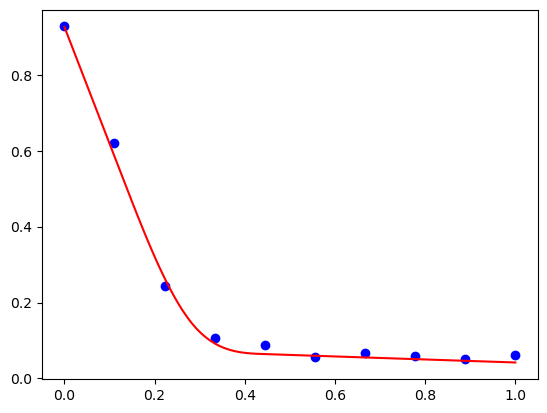

In [19]:
index = 10

plt.scatter(T[index], Y0[index], label='Ground Truth', color='blue')
plt.plot(T_to_plot[index], y_pred[index], label='Predicted', color='red')

In [20]:
sem_rep = episode.semantic_predictor.predict(V)

In [21]:
c = sem_rep.get_present_compositions()[0]

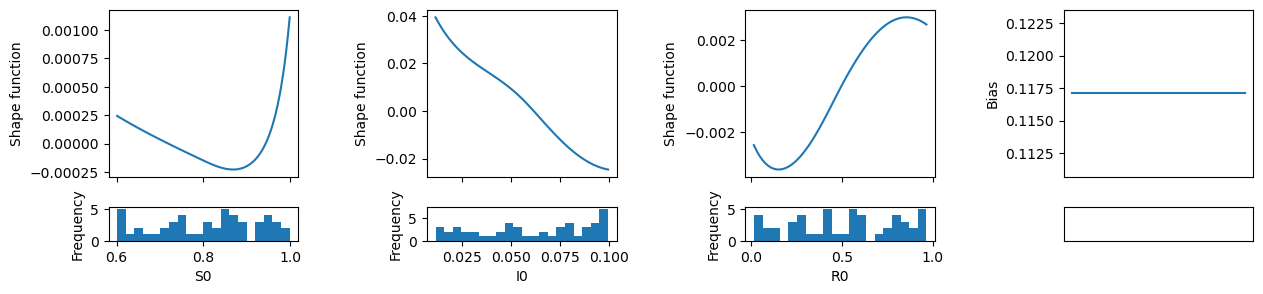

In [22]:
episode.semantic_predictor.property_map.per_composition[c].transition_point_predictor[1,'t'].gam.visualize()

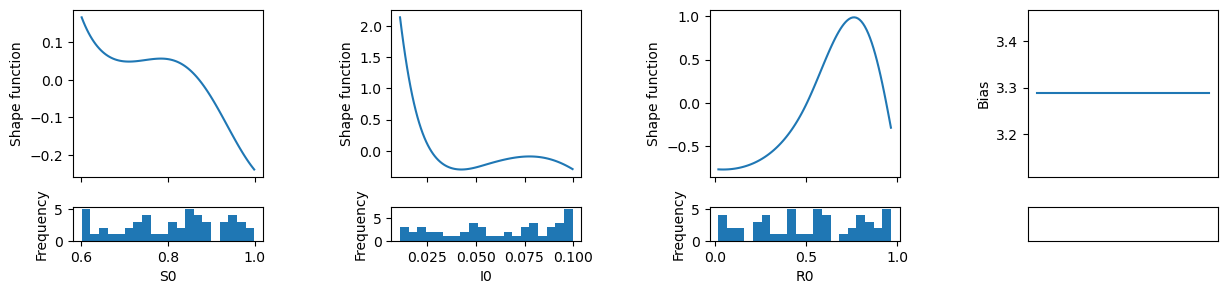

In [25]:
episode.semantic_predictor.property_map.per_composition[c].infinite_motif_predictor[0].gams[1].visualize()

In [12]:
episode.semantic_predictor.property_map.torch_models[c].property_module.final_motif_property_module.infinite_motif_properties_weights

Parameter containing:
tensor([[[-0.2596,  0.1183],
         [ 0.2440,  1.1646],
         [ 0.2886,  0.3866]],

        [[-0.2011, -0.1179],
         [ 0.1922, -0.7722],
         [-1.9003,  0.1307]],

        [[-0.7043,  0.3147],
         [ 0.1574,  0.3854],
         [ 0.9672, -0.9911]],

        [[ 0.3016, -0.1073],
         [ 1.0811,  0.1315],
         [ 1.5736,  0.7814]],

        [[ 0.9874, -1.4878],
         [ 0.5867,  0.1583],
         [ 0.6668, -0.9944]],

        [[-1.1893, -1.1959],
         [ 1.3119, -0.2098],
         [ 0.7818,  0.9897]]], requires_grad=True)

In [13]:
sem_rep.get_properties_by_composition(c)[0].second_derivative_end

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [14]:
y_pred

array([[0.85478467, 0.78899788, 0.72321109, 0.65742427, 0.59163745,
        0.52585061, 0.46006376, 0.3942769 , 0.32849002, 0.26270314],
       [0.70791471, 0.64425706, 0.58059907, 0.51694074, 0.4532821 ,
        0.38962314, 0.32596388, 0.26230431, 0.19864445, 0.13498431],
       [0.61638939, 0.5717214 , 0.5270533 , 0.48238509, 0.43771678,
        0.39304836, 0.34837985, 0.30371124, 0.25904253, 0.21437374],
       [0.60661107, 0.54793469, 0.48925791, 0.43058073, 0.37190317,
        0.31322524, 0.25454694, 0.19586829, 0.1371893 , 0.07850996],
       [0.92530811, 0.84615599, 0.76700381, 0.68785155, 0.60869923,
        0.52954685, 0.4503944 , 0.37124188, 0.29208931, 0.21293667],
       [0.96510226, 0.87659879, 0.78809528, 0.69959174, 0.61108817,
        0.52258456, 0.43408091, 0.34557723, 0.25707352, 0.16856978],
       [0.84265429, 0.77216811, 0.70168191, 0.6311957 , 0.56070946,
        0.49022321, 0.41973695, 0.34925066, 0.27876436, 0.20827805],
       [0.89179862, 0.82384192, 0.7558852

In [15]:
for c in composition_map.predict(V):
    print(str(c))

$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_{-+h})$
$(s_{--b}, s_